# Solar $S$ index

given conversions for high-resolution K index to the $S$ index from [Egeland+ 2017](http://adsabs.harvard.edu/abs/2017ApJ...835...25E)

Smid = 0.17499330372394944


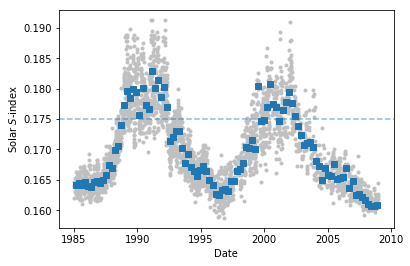

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binned_statistic
from astropy.time import Time
from astropy.io import ascii

table = ascii.read('solar/sp_iss.dat')
solar_times = Time(table['col2'], format='jd').decimalyear

table = table[(solar_times > 1985) & (solar_times < 2009)]

solar_times = Time(table['col2'], format='jd').decimalyear


# Use eqn 5 and 12 of Egeland 2017
k_iss = table['col3']
k_sp = (k_iss - 0.0062)/0.8781
solar_sind = 1.5 * k_sp + 0.031

nbins = 100
medians = binned_statistic(solar_times, solar_sind, statistic='median', bins=nbins)
std = binned_statistic(solar_times, solar_sind, statistic='std', bins=nbins)
solar_times_binned = 0.5*(medians.bin_edges[:-1] + medians.bin_edges[1:])
solar_sind_binned = medians.statistic
solar_sind_err_binned = std.statistic
plt.plot(solar_times, solar_sind, '.', color='silver')
plt.plot(solar_times_binned, solar_sind_binned, 's') #  yerr=solar_sind_err_binned
mids = 0.5*(solar_sind.max() + solar_sind.min())
plt.axhline(mids, ls='--', alpha=0.5)
print("Smid = {0}".format(mids))
plt.xlabel('Date')
plt.ylabel('Solar $S$-index')
plt.savefig('plots/solar_sind.png', bbox_inches='tight', dpi=200)

In [2]:
#time_at_max = np.count_nonzero(solar_sind > np.mean(solar_sind)) / len(solar_sind)
time_at_max = np.count_nonzero(solar_sind > mids) / len(solar_sind)
print(time_at_max)

0.2511641443538999


S_mid = 0.5378383166510131


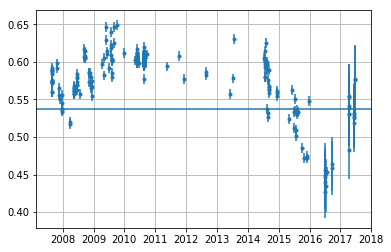

In [3]:
from toolkit import (json_to_stars, Measurement, stars_to_json, FitParameter,
                     parse_hires, StarProps)

props = dict(fontsize=15)

hat11 = json_to_stars('data/hat11.json')

f = FitParameter.from_text('calibration_constants/calibrated_f.txt')
c1 = FitParameter.from_text('calibration_constants/calibrated_c1.txt')
c2 = FitParameter.from_text('calibration_constants/calibrated_c2.txt')

hat11_s_apo = Measurement([s.s_apo.uncalibrated.value for s in hat11],
                          err=[s.s_apo.uncalibrated.err for s in hat11],
                          time=[s.s_apo.time.jd for s in hat11])

##############################################################################
# Solve for HAT-P-11 S-indices:
hat11_s_mwo_err = np.sqrt((f.value * hat11_s_apo.value * c1.err_lower)**2 +
                          (c1.value * f.value * hat11_s_apo.err)**2 +
                          c2.err_lower**2)

hat11_s_mwo = Measurement(c1.value * hat11_s_apo.value + c2.value,
                          err=hat11_s_mwo_err,
                          time=hat11_s_apo.time)

hat11_apo_calibrated = [StarProps(name='HAT-P-11', s_apo=sapo, s_mwo=smwo,
                                  time=sapo.time)
                        for sapo, smwo in zip(hat11_s_apo, hat11_s_mwo)]

stars_to_json(hat11_apo_calibrated, 'data/hat11_apo_calibrated.json')

#############################################################################
# Plot the S-index time series for HAT-P-11 with HIRES data too
hires = parse_hires('hat-p-11_svals.txt')

last_week_inds = np.argsort(hat11_s_apo.time.jd)[-8:]
hat11_s_mwo_mean = c1.value * hat11_s_apo.value[last_week_inds].mean() + c2.value
hat11_s_apo_err_mean = np.sqrt(np.sum(hat11_s_apo.err[last_week_inds]**2 /
                                      len(last_week_inds)**2))
hat11_s_mwo_mean_err = np.sqrt((hat11_s_apo.value[last_week_inds].mean() * c1.err_lower)**2 +
                               (c1.value * hat11_s_apo_err_mean)**2 +
                               c2.err_lower**2)


rm = (hires['time'].decimalyear < 2010.7) & (hires['time'].decimalyear > 2010.6)
rough_hires_err = np.std(hires[rm]['S-value'])

hat11_s_keck = Measurement(value=hires['S-value'].data,
                           err=rough_hires_err * np.ones(len(hires['S-value'].data)),
                           time=hires['time'])

hat11_keck_calibrated = [StarProps(name='HAT-P-11', s_mwo=s, time=s.time)
                         for s in hat11_s_keck]

times = np.hstack([hires['time'].decimalyear, hat11_s_apo.time.decimalyear])
sind = np.hstack([hires['S-value'], hat11_s_mwo.value])
sind_err = np.hstack([rough_hires_err * np.ones(len(hires['S-value'].data)), hat11_s_mwo.err])

sort = np.argsort(times)
times = times[sort]
sind = sind[sort]
sind_err = sind_err[sort]

plt.errorbar(times, sind, yerr=sind_err, fmt='.')
mids_h11 = 0.5*(sind.max()+sind.min())
print("S_mid = {0}".format(mids_h11))
plt.axhline(mids_h11)
plt.xticks(range(2008, 2019))
plt.grid()